# Classification problem with Fake and Real news
## BuffML www.buffml.com

In this project, I build a text classification to define whether or not a certain article is fake news or real news. Using Natural Language Processing methodologies in Python and Classification Theory, I reached an accuracy of 0.945455 for classifying news as fake.

In [ ]:
## This file has all imports and helper functions used throughout the notebook
%run python_helper.py
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clean & Save Data

Inspecting the data files, we noticed several issues for processing the traning dataset correctly. Using Regular Expression, we convert all commas between quotations to a pipe, so the CSV parsing works correctly with all values in their correct columns.

In [ ]:
input_str = open("/content/drive/MyDrive/dataset/fake_or_real_news_training.csv", encoding= 'utf-8')

# Remove all new lines
noNewLines = re.sub("\n", "", input_str.read())

# re-add new line at end of each row
noNewLines = re.sub("X1,X2", "X1,X2\n", noNewLines)


noNewLines = re.sub(",FAKE[,]+", ",FAKE,,\n", noNewLines)
# noNewLines = re.sub(",FAKE,(?!,)",",FAKE,,\n",noNewLines)
# noNewLines = re.sub(",FAKE,,(?!,)",",FAKE,,\n",noNewLines)

noNewLines = re.sub(",REAL[,]+", ",REAL,,\n", noNewLines)
# noNewLines = re.sub(",REAL,(?!,)",",REAL,,\n",noNewLines)
# noNewLines = re.sub(",REAL,,(?!,)",",REAL,,\n",noNewLines)


# Replace any commas between two quotes with |
lines = noNewLines.split('\n')

def removeComma(g):
      t = g.groups()
      t = [t[0], t[1].replace(',', ' |'), t[2], t[3]]
      return "".join(t)

betweenQuotes = lambda line: re.sub(r'(.*,")(.*)(",)(.*)', lambda x: removeComma(x), line)

secondCol = lambda line: re.sub(r'^([0-9]+,)(.*,.*)(,\")(.*)$', lambda x: removeComma(x), line, 1)


lines = [betweenQuotes(l) for l in lines]
lines = [secondCol(l) for l in lines]

finalString = '\n'.join(lines)



### Save cleaned file

In [ ]:
file = open('fake_or_real_news_training_CLEANED.csv', 'w',encoding= 'utf-8')
file.write(finalString)
file.close()

# Data Preparation

In [ ]:
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")
test = pd.read_csv("/content/drive/MyDrive/dataset/fake_or_real_news_test.csv")

In [ ]:
len(train)

3997

In [ ]:
len(test)

2321

In [ ]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,NaN,NaN


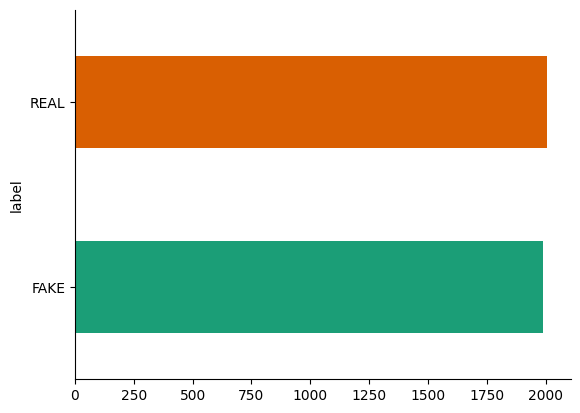

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,NaN,NaN


In [ ]:
train = train.drop(['X1', 'X2'], axis=1)

We study if the dataset is unbalanced. From the plot we see this is not the case, as there is a similar amount of Fake and Real news articles. No further actions have to be taken.

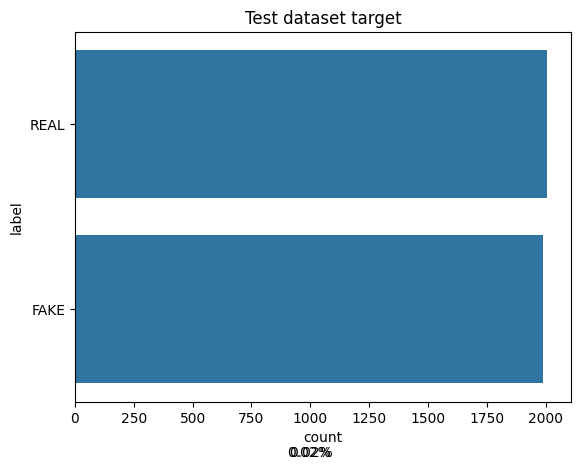

In [ ]:
from collections import Counter
ax = sns.countplot(train.label, order=[x for x, count in sorted(Counter(train.label).items(), key=lambda x: -x[1])])


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center")
ax.set_title("Test dataset target")
show()

In order to not do double work by doing operations on our train and testset and to analyze general distributions of our data, we stack train and test in df.

In [ ]:
test['label'] = None  # empty label for test

df = pd.concat([train, test])

In [ ]:
len(df)

6318

In [ ]:
df.tail()

,ID,title,text,label
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None
2320,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None


# Data Preprocessing

In this part we will be cleaning the articles with the help of different NLP techniques, of which we will first explain the concept and its importance.

In order to take into account the title in our accuracy prediction, we created an extra column that combines text and title. We will not do separate predictions on the title since these might classify as e.g. Fake news, whether the actual text with more explanation tells a Real story.

In [ ]:
df['title_and_text'] = df['title'] +' '+ df['text']
df.tail()

,ID,title,text,label,title_and_text
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se..."
2320,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...


<Axes: >

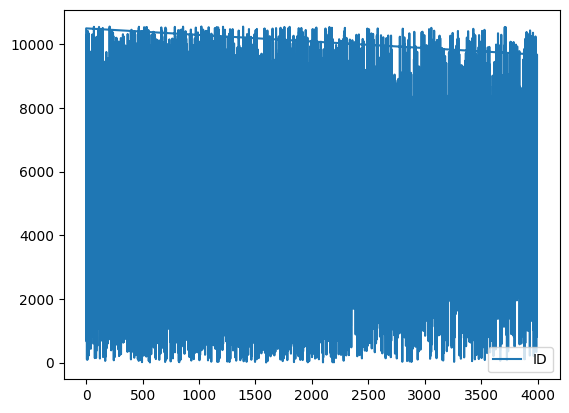

In [ ]:
df.plot()

preprocess() can be found in python_helper.py
Here you can read the explanations of the preprocess steps we took

1. lowercase the text

This preprocessing step is done so words van later be cross checked with the stopword and pos_tag dictionaries. For future analysis purposes, it could have been benefitial to analyze text with a lot of words in capital letters, by adding a flag variable.

2. remove the words counting just one letter

Idem step one.

3. remove the words that contain numbers

Idem step one.

4. tokenize the text and remove punctuation

We performed tokenization with the base python .string function, to split sentences into words (tokens).

5. remove all stop words

Relevant analysis of the text depends on the most recurring words. Stopwords including words as "the", "as" and "and" appear a lot in a text, but do not give relevant explanation. For this reason they are removed.

6. remove tokens that are empty

After tokenization, we have to make sure all tokens taken into account contribute to the label prediction.

7. pos tag the text

We use the pos_tag function included in the ntlk library. This classifies our tokenized words as a noun, verb, adjective or adverb and adds to the understaning of the articles.

8. lemmatize the text

In order to normalize the text, we apply lemmatization. In this way, words with the same root are processed equally e.g. when took or taken are read in the text, they are lemmatized to take, infinitive of the two verbs.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df['preprocessed_text'] = df['title_and_text'].apply(lambda x: preprocess(x))

In [ ]:
## Save preprocessed df
df.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)

In [ ]:
df = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
df = df.astype(object).replace(np.nan, 'None')

In [ ]:
df.tail()

,ID,title,text,label,title_and_text,preprocessed_text
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...
6317,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...,jeb bush suddenly attack trump here's matter j...


### Split Train and Test again after pre-processing is done

In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df)


Train dataset (Full)
(3997, 7)
Train dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text', 'encoded_label']

Train CV dataset (subset)
(2677, 7)
Train Holdout dataset (subset)
(1320, 7)

Test dataset
(2321, 6)
Test dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text']


In [ ]:
encoder

LabelEncoder()

# Baseline Modelling

First, we create a dataframe called models to keep track of different models and their scores.

In [ ]:
models = pd.DataFrame(columns=['model_name', 'model_object', 'score'])

### Vectorizing dataset

For any text to be fed to a model, the text has to be transformed into numerical values. This process is called vectorizing and will be redone everytime a new feature is added.

In [ ]:
count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.preprocessed_text)

train_cv_vector = count_vectorizer.transform(train_cv.preprocessed_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.preprocessed_text)
test_vector = count_vectorizer.transform(test.preprocessed_text)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
count_vect.get_feature_names_out()[:10]

array(['___', '_blank', '_derosa', '_rt_op_edge', '_strauss', 'aa', 'aaa',
       'aaahhh', 'aab', 'aachen'], dtype=object)

## Baseline Model 1: SVC

We create a baseline classification model with a support vector machine, a good model to handle complex classifications.

Baseline Model 1: SVC
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.909 (+/-0.022) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.902 (+/-0.030) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.893 (+/-0.030) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.886 (+/-0.011) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=100, gamma

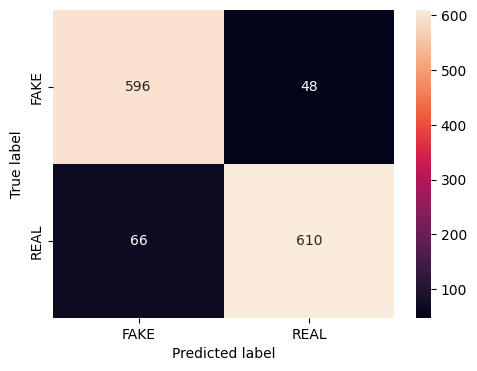


Accuracy:
0.9136363636363637


In [ ]:
SVC_classifier = runModel(encoder,
               train_cv_vector,
               train_cv_label,
               train_holdout_vector,
               train_holdout.label,
               "svc",
               "Baseline Model 1: SVC")
models.loc[len(models)] = SVC

## Baseline Model 2: Naïve Bayes

from IPython.display import Image
Image("/Users/Gerald/Personal Drive/IE MBD/Term III/Natural Language Processing/Ass 1/NLP Fake News Predection | Gerald | Hatem/real_vs_fake.png")

With this hand drawn example (text: *rude hell worth*), we explain why the Naïve Bayes model is helpful for our classification. The labels Real and Fake text are hidden, but every word, based on our training data, has a certain probability to belong to one of the two categories. The final score is calculated, multiplying all probabilities of the words (0.006 for real, 0.288 for fake). The algo thus does not take into account the order of the words in the multiplication. *rude hell worth* will be classified as fake.

Baseline Model 2: Naiive Bayes
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.887 (+/-0.021) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


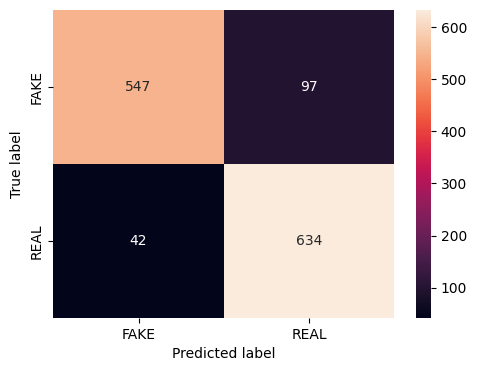


Accuracy:
0.8946969696969697


In [ ]:
NB = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "nb",
              "Baseline Model 2: Naiive Bayes")
models.loc[len(models)] = NB

## Baseline Model 3: MaxEnt Classifier

Baseline Model 3: MaxEnt Classifier
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.877 (+/-0.023) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.913 (+/-0.011) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.929 (+/-0.012) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.926 (+/-0.019) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.916 (+/-0.026) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100,

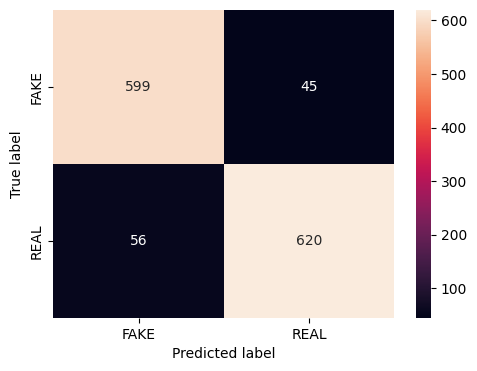


Accuracy:
0.9234848484848485


In [ ]:
maxEnt = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "maxEnt",
              "Baseline Model 3: MaxEnt Classifier")
models.loc[len(models)] = maxEnt

# Baseline Models Summary

In [ ]:
models

,model_name,model_object,score
0,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>
1,Baseline Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Baseline Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485


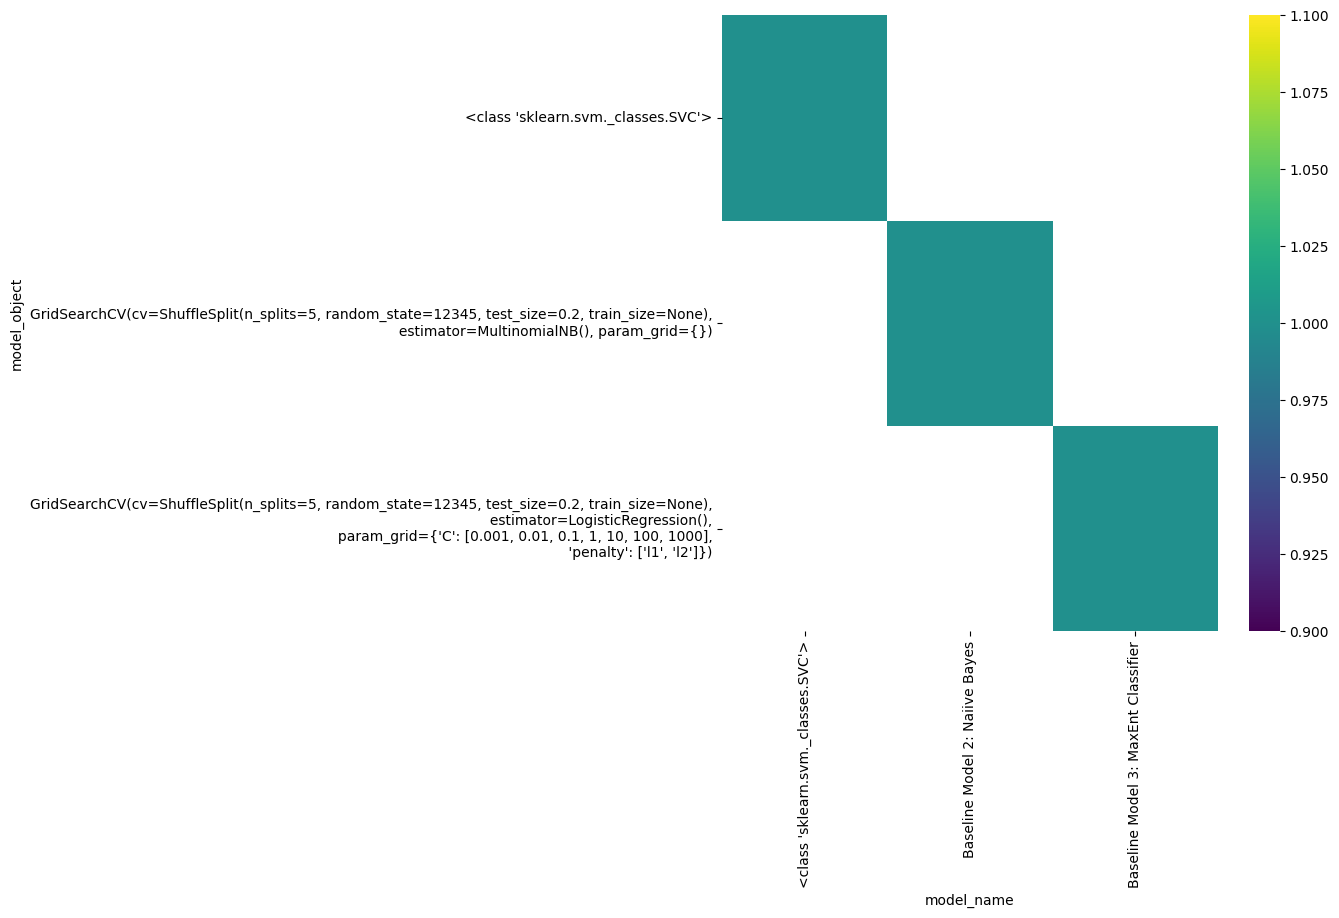

In [ ]:
# @title model_name vs model_object

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['model_object'].value_counts()
    for x_label, grp in models.groupby('model_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('model_name')
_ = plt.ylabel('model_object')

<Axes: xlabel='model_name', ylabel='count'>

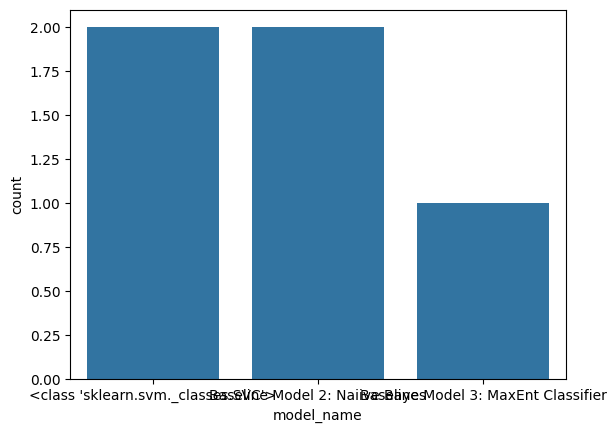

In [ ]:
# @title Count of Models by Model Name

sns.countplot(x="model_name", data=models)

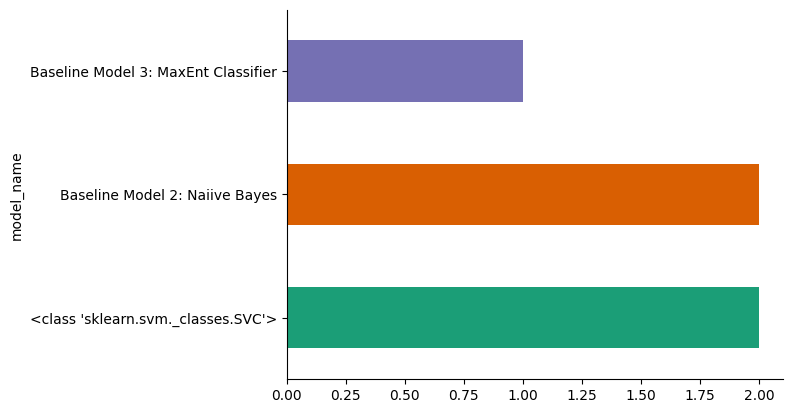

In [ ]:
# @title model_name

from matplotlib import pyplot as plt
import seaborn as sns
models.groupby('model_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Feature Engin|eering

- Explicit POS tagging
- TF-IDF weighting
- Bigram Count Vectorizer

==> Select Final Model and predict on test

## 1. POS Tagging

Adding a prefix to each word with its type (Noun, Verb, Adjective,...).
e.g: I went to school => PRP-I VBD-went TO-to NN-school

Also, after lemmatization it will be 'VB-go NN-school', which indicates the semantics and distinguishes the purpose of the sentence.

This will help the classifier differentiate between different types of sentences.

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['pos_tagged_text'] = df['preprocessed_text'].apply(lambda x: pos_tag_words(x))

In [ ]:
df.head()

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...,NN-watch JJ-exact NN-moment NN-paul JJ-ryan NN...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...,NN-kerry VBP-go JJ-paris NN-gesture JJ-sympath...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,NN-bernie NN-supporter NN-twitter JJ-erupt NN-...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,NN-battle JJ-new NN-york JJ-primary NN-matter ...


### Rerun Models on pos-tagged text (FE1)

In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.preprocessed_text)

train_cv_vector = count_vectorizer.transform(train_cv.pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.pos_tagged_text)
test_vector = count_vectorizer.transform(test.pos_tagged_text)

a. SVC with FE1

SVC on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.921 (+/-0.025) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.914 (+/-0.020) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.912 (+/-0.028) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.912 (+/-0.022) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 100, 'kernel': 'linear'}


Best Estimator Params
SVC(C=100, gamm

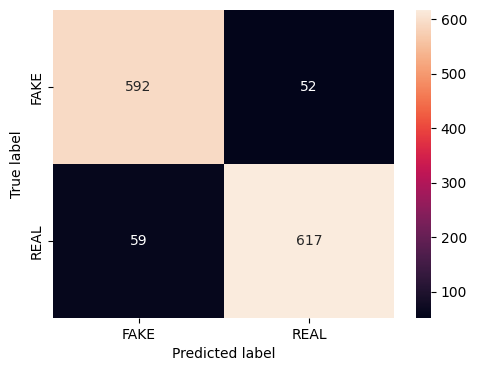


Accuracy:
0.9159090909090909


In [ ]:
SVC_pos_tag = runModel(encoder,
               train_cv_vector,
               train_cv_label,
               train_holdout_vector,
               train_holdout.label,
               "svc",
               "SVC on pos-tagged text")
models.loc[len(models)] = SVC_pos_tag

b. NB_pos_tag with FE1

Naiive Bayes on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.889 (+/-0.017) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


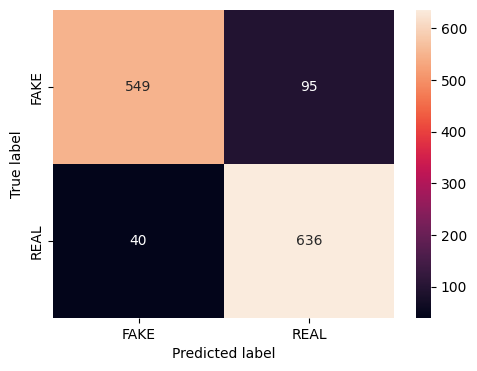


Accuracy:
0.8977272727272727


In [ ]:
NB_pos_tag = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "nb",
              "Naiive Bayes on pos-tagged text")
models.loc[len(models)] = NB_pos_tag

c. maxEnt with FE1

MaxEnt Classifier on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.885 (+/-0.013) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.918 (+/-0.015) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.928 (+/-0.029) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.932 (+/-0.026) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.932 (+/-0.026) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100

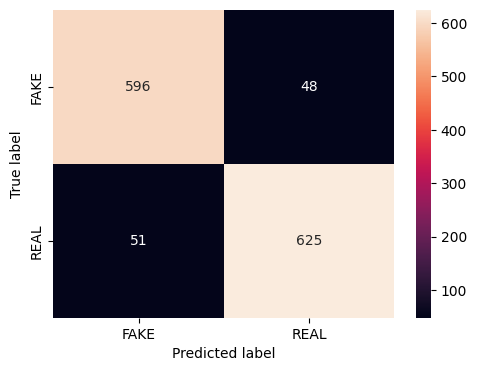


Accuracy:
0.925


In [ ]:
maxEnt_pos_tag = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "maxEnt",
              "MaxEnt Classifier on pos-tagged text")
models.loc[len(models)] = maxEnt_pos_tag

In [ ]:
models

,model_name,model_object,score
0,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>
1,Baseline Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Baseline Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925


<h3 style="color:blue">
There seems to be a slight increase in Accuracy after pos-tagging.
</h3>

## 2. TF-IDF weighting

Try to add weight to each word using TF-IDF
<img src="https://cdn-images-1.medium.com/max/800/1*_OsV8gO2cjy9qcFhrtCdiw.jpeg" width="350px"/>

We are going to calculate the TFIDF score of each term in a piece of text. The text will be tokenized into sentences and each sentence is then considered a text item.

We will also apply those on the cleaned text and the concatinated POS_tagged text.

In [ ]:
df["clean_and_pos_tagged_text"] = df['preprocessed_text'] + ' ' + df['pos_tagged_text']

In [ ]:
df.head(5)

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...,NN-watch JJ-exact NN-moment NN-paul JJ-ryan NN...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...,NN-kerry VBP-go JJ-paris NN-gesture JJ-sympath...,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,NN-bernie NN-supporter NN-twitter JJ-erupt NN-...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,NN-battle JJ-new NN-york JJ-primary NN-matter ...,battle new york primary matter primary day new...


In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = count_vectorizer.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = count_vectorizer.transform(test.clean_and_pos_tagged_text)


tf_idf = TfidfTransformer(norm="l2")
train_cv_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_tf_idf = tf_idf.fit_transform(test_vector)

### Rerun Models on preprocessed + pos-tagged (FE1) + TF-IDF weighted text (FE2)

a. SVC with FE1 and FE2

SVC on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Est

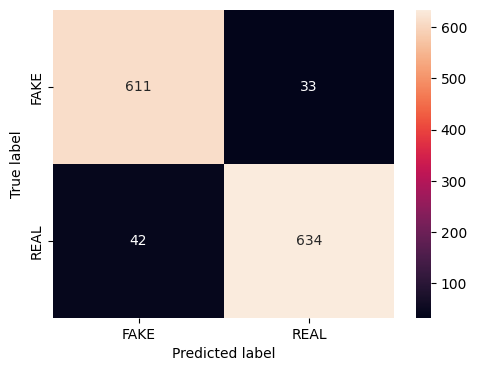


Accuracy:
0.9431818181818182


In [ ]:
SVC_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = SVC_tf_idf

b. NB with FE1 and FE2

Naiive Bayes on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.781 (+/-0.039) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


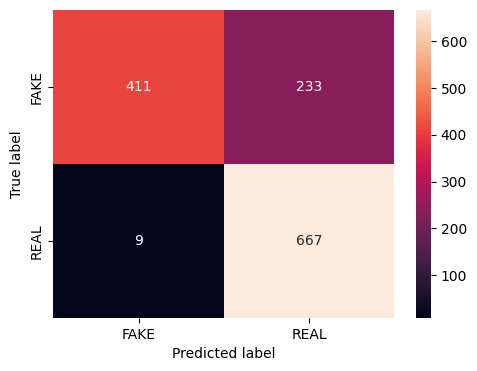


Accuracy:
0.8166666666666667


In [ ]:
NB_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "nb",
              "Naiive Bayes on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = NB_tf_idf

c. maxEnt with FE1 and FE2

MaxEnt on preprocessed+pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.554 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.023) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.907 (+/-0.004) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.931 (+/-0.022) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for

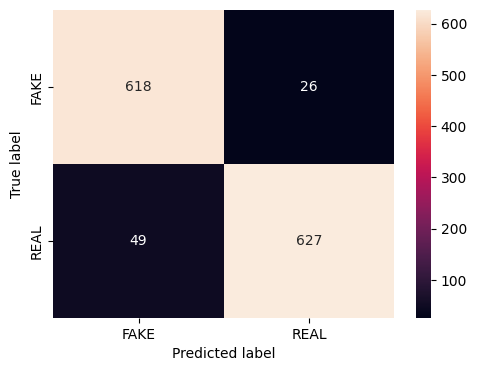


Accuracy:
0.9431818181818182


In [ ]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on preprocessed+pos-tagged TF-IDF weighted text")
models.loc[len(models)] = maxEnt_tf_idf

In [ ]:
models

,model_name,model_object,score
0,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>
1,Baseline Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Baseline Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925
6,SVC on preprocessed+pos-tagged TF-IDF weighted...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
7,Naiive Bayes on preprocessed+pos-tagged TF-IDF...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.816667
8,MaxEnt on preprocessed+pos-tagged TF-IDF weigh...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182


<h3 style="color:blue">
Using TF-IDF increased the score to ~94.5% with SVC and Max-Ent models.
<br><br>
Naive-Bayes rather decreased the score. Therefore we drop it from the pipeline.
</h3>

## 3. Use Bigram Vectorizer instead of regular vectorizer

For FE3, we use the Trigram vectorizer, which vectorizes **triplets of words** rather than each word separately. *In this short example sentence*, the trigrams are "In this short", "this short example" and "short example sentence".

In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,2))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = trigram_vect.transform(test.clean_and_pos_tagged_text)

In [ ]:
tf_idf = TfidfTransformer(norm="l2")
train_cv_bigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_bigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_bigram_tf_idf = tf_idf.fit_transform(test_vector)

### Rerun Models on preprocessed + pos-tagged (FE1) + TF-IDF weighted (FE2) + Trigram vectorized text (FE3)

a. SVC with FE1, FE2 and FE3

SVC on bigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=10, 

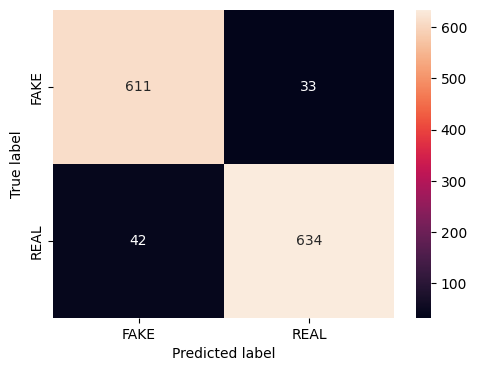


Accuracy:
0.9431818181818182


In [ ]:
SVC_trigram_tf_idf = runModel(encoder,
               train_cv_bigram_tf_idf,
               train_cv_label,
               train_holdout_bigram_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on bigram vect.+ TF-IDF")
models.loc[len(models)] = SVC_trigram_tf_idf

b. maxEnt with FE1, FE2 and FE3

In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,3))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)

In [ ]:
tf_idf = TfidfTransformer(norm="l2")
train_cv_trigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_trigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)

MaxEnt on trigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.554 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.023) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.907 (+/-0.004) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.931 (+/-0.022) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100, 'pe

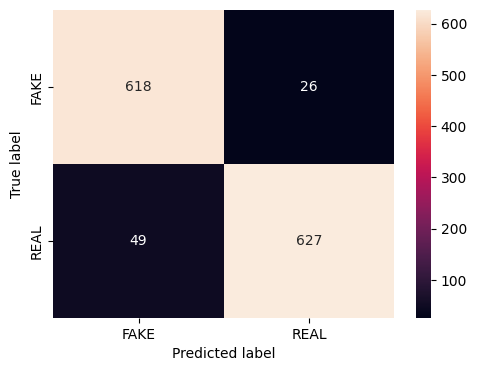


Accuracy:
0.9431818181818182


In [ ]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_trigram_tf_idf,
               train_cv_label,
               train_holdout_trigram_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on trigram vect.+ TF-IDF")
models.loc[len(models)] = maxEnt_tf_idf

In [ ]:
models

,model_name,model_object,score
0,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.svm._classes.SVC'>
1,Baseline Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Baseline Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925
6,SVC on preprocessed+pos-tagged TF-IDF weighted...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
7,Naiive Bayes on preprocessed+pos-tagged TF-IDF...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.816667
8,MaxEnt on preprocessed+pos-tagged TF-IDF weigh...,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
9,SVC on bigram vect.+ TF-IDF,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182


<h3 style="color:blue">
It looks like the "MaxEnt on trigram vect.+ TF-IDF" is the best model with the highest score. We will use it to predict and classify the testset.
</h3>

# Predicting on test dataset

## 1. Train on whole data and predict on test

### PREPROCESSED data

In [ ]:
test = pd.read_csv("fake_or_real_news_test.csv")
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")

In [ ]:
train['title_and_text'] = train['title'] +' '+ train['text']
train['preprocessed_text'] = train['title_and_text'].apply(lambda x: preprocess(x))

In [ ]:
test['title_and_text'] = test['title'] +' '+ test['text']
test['preprocessed_text'] = test['title_and_text'].apply(lambda x: preprocess(x))

In [ ]:
test.head()

,ID,title,text,title_and_text,preprocessed_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...


In [ ]:
## Save preprocessed df
train.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)

In [ ]:
# Save preprocessed df
test.to_csv("fake_or_real_news_test_PREPROCESSED.csv", index=False)

In [ ]:
train = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
train = train.astype(object).replace(np.nan, 'None')

test = pd.read_csv("fake_or_real_news_test_PREPROCESSED.csv")
test = test.astype(object).replace(np.nan, 'None')

In [ ]:
test = test.astype(object).replace(np.nan, 'None')

In [ ]:
test.head()

,ID,title,text,title_and_text,preprocessed_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...


In [ ]:
train.head()

,ID,title,text,label,X1,X2,title_and_text,preprocessed_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,None,None,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,None,None,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,None,None,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,None,None,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,None,None,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...


### POS Tagging

In [69]:
train['pos_tagged_text'] = train['preprocessed_text'].apply(lambda x: pos_tag_words(x))
test['pos_tagged_text'] = test['preprocessed_text'].apply(lambda x: pos_tag_words(x))

### merge clean and pos tagged

In [70]:
train["clean_and_pos_tagged_text"] = train['preprocessed_text'] + ' ' + train['pos_tagged_text']
test["clean_and_pos_tagged_text"] = test['preprocessed_text'] + ' ' + train['pos_tagged_text']

In [71]:
train.head(1)

,ID,title,text,label,X1,X2,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,None,None,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...


In [73]:
test.head(1)

,ID,title,text,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...,VB-september JJ-new NN-home NN-sale JJ-rise——-...,september new home sale rise——-back level sept...


## Modelling using MaxEnt on trigram vect.+ TF-IDF Grid Search Best params

### Trigram + Tfdif + classifier pipeline

In [74]:
from sklearn.pipeline import Pipeline
trigram_vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,3))
tf_idf = TfidfTransformer(norm="l2")
classifier = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

pipeline = Pipeline([
     ('trigram_vectorizer', trigram_vectorizer),
     ('tfidf', tf_idf),
     ('clf', classifier),
 ])


In [75]:
pipeline.fit(train.clean_and_pos_tagged_text, encoder.fit_transform(train.label.values))

Pipeline(steps=[('trigram_vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=1000, multi_class='multinomial',
                                    solver='saga'))])

In [76]:
import pickle
pickle.dump( pipeline, open( "pipeline.pkl", "wb" ) )

## 2. Predicting on test

In [77]:
print(colored("Predicting on test", 'blue'))
test_predictions = test_predictions = pipeline.predict(test.clean_and_pos_tagged_text)


Predicting on test


In [78]:
test_predictions

array([0, 0, 1, ..., 1, 1, 1])

In [79]:
test_predictions_decoded = encoder.inverse_transform( test_predictions )

In [80]:
predictions = test
predictions["label"] = test_predictions_decoded

In [81]:
predictions.shape

(2321, 8)

In [82]:
predictions.head()

,ID,title,text,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text,label
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...,VB-september JJ-new NN-home NN-sale JJ-rise——-...,september new home sale rise——-back level sept...,FAKE
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...,NN-obamacare NN-doomsday NN-cult MD-ca RB-n't ...,obamacare doomsday cult can't admit wrong cong...,FAKE
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...,NN-sander NNS-cruz VBP-resist NN-pressure JJ-n...,sander cruz resist pressure ny loss vow fight ...,REAL
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...,JJ-survive NN-escape NN-prisoner JJ-likely NN-...,survive escape prisoner likely fatigue prone m...,REAL
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...,NN-clinton NN-sander NN-neck NN-neck NN-califo...,clinton sander neck neck california primary ma...,REAL


In [83]:
predictions.label.describe()

count     2321
unique       2
top       REAL
freq      1330
Name: label, dtype: object

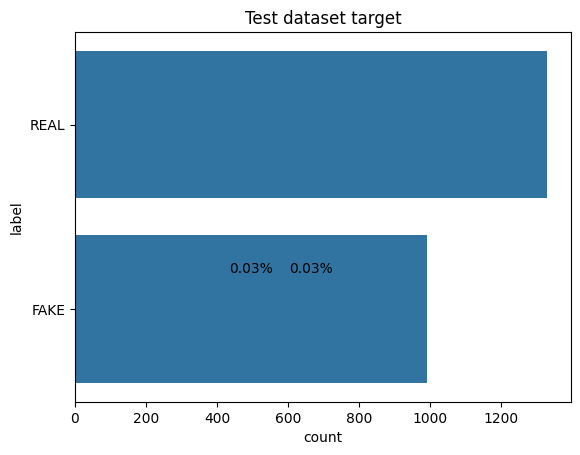

In [87]:
import collections
ax = sns.countplot(predictions.label,
                order=[x for x, count in sorted(collections.Counter(predictions.label).items(),
                key=lambda x: -x[1])])


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0,
            '{:1.2f}%'.format(height/len(predictions)*100),
            ha="center")
ax.set_title("Test dataset target")
show()

In [91]:
predictions.drop(columns=["title","text","title_and_text","preprocessed_text","pos_tagged_text","clean_and_pos_tagged_text"]).head()

,ID,label
0,10498,FAKE
1,2439,FAKE
2,864,REAL
3,4128,REAL
4,662,REAL


from matplotlib import pyplot as plt
_df_3['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('ID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ID')):
  _plot_series(series, series_name, i)
  fig.legend(title='ID', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label')):
  _plot_series(series, series_name, i)
  fig.legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['label'].value_counts()
    for x_label, grp in _df_9.groupby('ID')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ID')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['ID'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='ID', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='index', y='label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

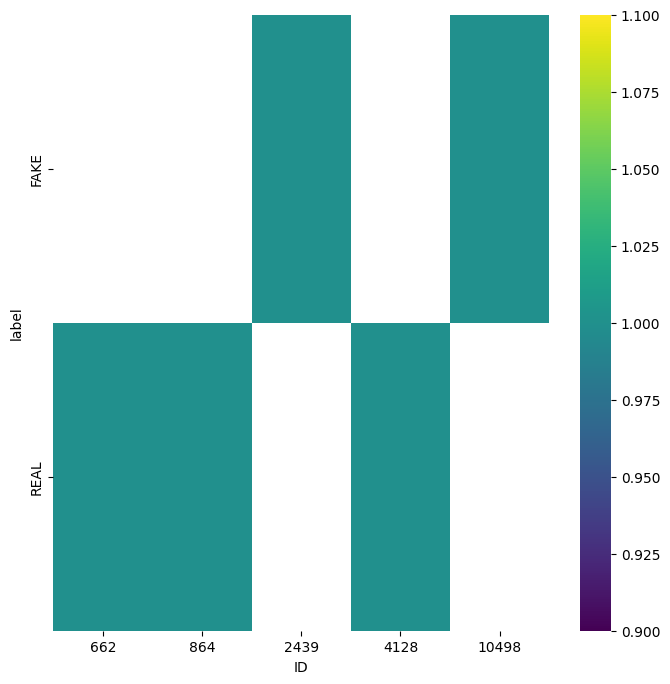

In [89]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['label'].value_counts()
    for x_label, grp in _df_2.groupby('ID')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ID')
_ = plt.ylabel('label')

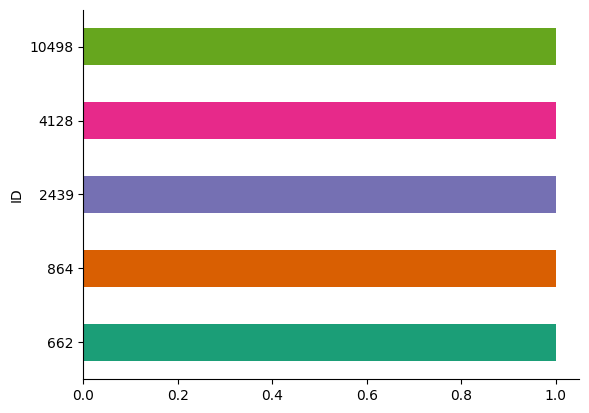

In [88]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('ID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [86]:
predictions.to_csv("TEST_PREDICTIONS.csv", index=False)